In [13]:
import h5py
import numpy as np
from concurrent.futures import ThreadPoolExecutor

def read_year_data(f, variable, year):
    return f[variable][str(year)][:]

def read_hdf5_data_parallel(file_path, variable, start_year, end_year):
    years = range(start_year, end_year + 1)
    data_list = []

    with h5py.File(file_path, 'r') as f:
        with ThreadPoolExecutor(max_workers=8) as executor:
            futures = [executor.submit(read_year_data, f, variable, year) for year in years]
            for future in futures:
                data_list.append(future.result())

    return np.concatenate(data_list, axis=0)


In [14]:
import pandas as pd
# Load data
ppt = read_hdf5_data_parallel('/data/PRISM/Michigan_250m_1990_2022.h5', 'ppt', 2000, 2004)
tmin = read_hdf5_data_parallel('/data/PRISM/Michigan_250m_1990_2022.h5', 'tmin', 2000, 2004)
tmax = read_hdf5_data_parallel('/data/PRISM/Michigan_250m_1990_2022.h5', 'tmax', 2000, 2004)
labels = pd.read_csv('/home/talhamuh/water-research/CNN-LSMT/data/processed/streamflow_data/combined_streamflow_all_vpuids.csv')
labels = labels.iloc[:1825]
# Ensure consistency between input data and labels
min_length = min(len(ppt), len(tmin), len(tmax), len(labels))
min_length = 1825
ppt = ppt[:min_length]
tmin = tmin[:min_length]
tmax = tmax[:min_length]
labels = labels[:min_length]

In [15]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from dataset import ClimateDataset
# Assuming your data is already loaded in ClimateDataset class
dataset = ClimateDataset(ppt, tmin, tmax, labels)

# Store original (un-normalized) data for comparison
ppt_original = dataset.ppt.numpy()
tmin_original = dataset.tmin.numpy()
tmax_original = dataset.tmax.numpy()


In [16]:
ppt_original[1, :, :]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:

# Normalize the data (standardization)
dataset.ppt_mean = torch.mean(dataset.ppt, dim=(1, 2), keepdim=True)
dataset.ppt_std = torch.std(dataset.ppt, dim=(1, 2), keepdim=True)
dataset.ppt_standardize = (dataset.ppt - dataset.ppt_mean) / dataset.ppt_std

dataset.tmin_mean = torch.mean(dataset.tmin, dim=(1, 2), keepdim=True)
dataset.tmin_std = torch.std(dataset.tmin, dim=(1, 2), keepdim=True)
dataset.tmin_standardize = (dataset.tmin - dataset.tmin_mean) / dataset.tmin_std

dataset.tmax_mean = torch.mean(dataset.tmax, dim=(1, 2), keepdim=True)
dataset.tmax_std = torch.std(dataset.tmax, dim=(1, 2), keepdim=True)
dataset.tmax_standardize = (dataset.tmax - dataset.tmax_mean) / dataset.tmax_std

In [18]:
# Convert normalized tensors to NumPy arrays
ppt_normalized_standardize = dataset.ppt_standardize.numpy()
tmin_normalized_standardize = dataset.tmin_standardize.numpy()
tmax_normalized_standardize = dataset.tmax_standardize.numpy()

In [19]:
ppt_normalized_standardize[1, :, :]

array([[-0.63225013, -0.63225013, -0.63225013, ..., -0.63225013,
        -0.63225013, -0.63225013],
       [-0.63225013, -0.63225013, -0.63225013, ..., -0.63225013,
        -0.63225013, -0.63225013],
       [-0.63225013, -0.63225013, -0.63225013, ..., -0.63225013,
        -0.63225013, -0.63225013],
       ...,
       [-0.63225013, -0.63225013, -0.63225013, ..., -0.63225013,
        -0.63225013, -0.63225013],
       [-0.63225013, -0.63225013, -0.63225013, ..., -0.63225013,
        -0.63225013, -0.63225013],
       [-0.63225013, -0.63225013, -0.63225013, ..., -0.63225013,
        -0.63225013, -0.63225013]], dtype=float32)

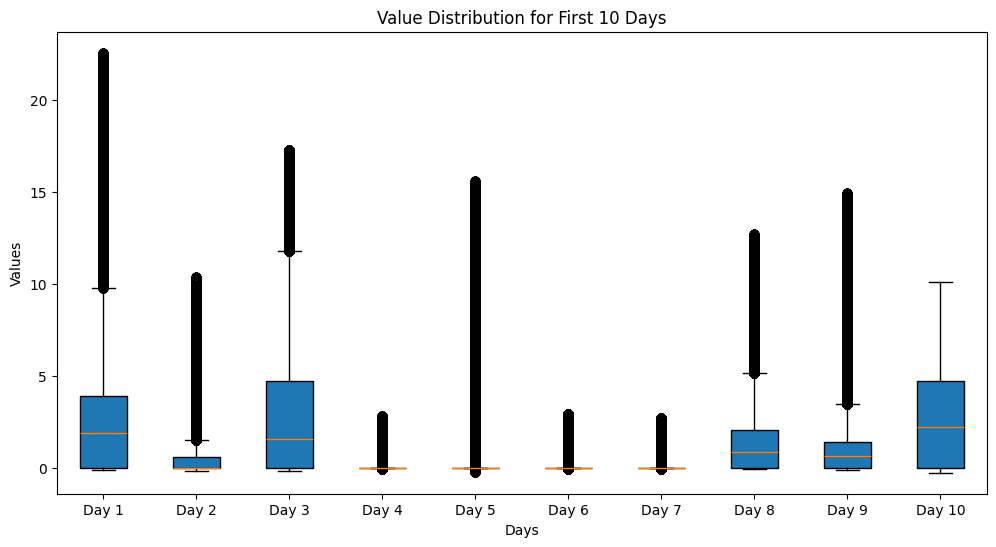

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming your numpy array is named 'data'
# Shape: (days, height, width)
# For example: data = np.random.rand(1825, 1849, 1458)

# Select the first 10 days
first_10_days = ppt_original[10:20, :, :]

# Flatten each day's 2D array into 1D array for plotting
flattened_data = [first_10_days[day].flatten() for day in range(10)]

# Plotting
plt.figure(figsize=(12, 6))
plt.boxplot(flattened_data, vert=True, patch_artist=True, tick_labels=[f'Day {i+1}' for i in range(10)])
plt.title('Value Distribution for First 10 Days')
plt.xlabel('Days')
plt.ylabel('Values')
plt.show()


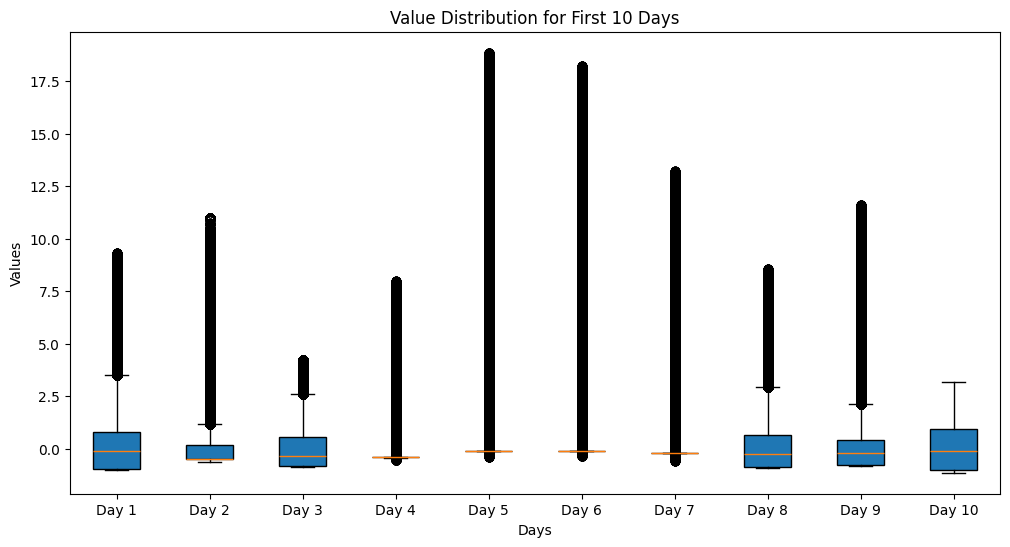

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming your numpy array is named 'data'
# Shape: (days, height, width)
# For example: data = np.random.rand(1825, 1849, 1458)

# Select the first 10 days
first_10_days = ppt_normalized_standardize[10:20, :, :]

# Flatten each day's 2D array into 1D array for plotting
flattened_data = [first_10_days[day].flatten() for day in range(10)]
# Plotting
plt.figure(figsize=(12, 6))
plt.boxplot(flattened_data, vert=True, patch_artist=True, tick_labels=[f'Day {i+1}' for i in range(10)])
plt.title('Value Distribution for First 10 Days')
plt.xlabel('Days')
plt.ylabel('Values')
plt.show()

In [56]:

# Assuming your data is already loaded in the ClimateDataset class
dataset = ClimateDataset(ppt, tmin, tmax, labels)

# Store original (un-normalized) data for comparison
ppt_original = dataset.ppt.numpy()
tmin_original = dataset.tmin.numpy()
tmax_original = dataset.tmax.numpy()

# Log normalization for PPT, TMIN, and TMAX
# Add a small constant to avoid log(0) or log of negative values

# PPT (Precipitation) log normalization
ppt_shifted = dataset.ppt + 0.1
dataset.ppt_log = torch.log(ppt_shifted)

# TMIN (Min Temperature) log normalization
tmin_shifted = dataset.tmin + 0.1
dataset.tmin_log = torch.log(tmin_shifted)

# TMAX (Max Temperature) log normalization
tmax_shifted = dataset.tmax + 0.1
dataset.tmax_log = torch.log(tmax_shifted)

# Note: If your data can have large values, consider normalizing after log


In [57]:
# Convert normalized tensors to NumPy arrays
ppt_log_normalized = dataset.ppt_log.numpy()
tmin_log_normalized = dataset.tmin_log.numpy()
tmax_log_normalized = dataset.tmax_log.numpy()

ppt_log_normalized[1,:,:]

array([[-2.3025851, -2.3025851, -2.3025851, ..., -2.3025851, -2.3025851,
        -2.3025851],
       [-2.3025851, -2.3025851, -2.3025851, ..., -2.3025851, -2.3025851,
        -2.3025851],
       [-2.3025851, -2.3025851, -2.3025851, ..., -2.3025851, -2.3025851,
        -2.3025851],
       ...,
       [-2.3025851, -2.3025851, -2.3025851, ..., -2.3025851, -2.3025851,
        -2.3025851],
       [-2.3025851, -2.3025851, -2.3025851, ..., -2.3025851, -2.3025851,
        -2.3025851],
       [-2.3025851, -2.3025851, -2.3025851, ..., -2.3025851, -2.3025851,
        -2.3025851]], dtype=float32)

[array([-2.3025851, -2.3025851, -2.3025851, ..., -2.3025851, -2.3025851,
       -2.3025851], dtype=float32), array([-2.3025851, -2.3025851, -2.3025851, ..., -2.3025851, -2.3025851,
       -2.3025851], dtype=float32), array([-2.3025851, -2.3025851, -2.3025851, ..., -2.3025851, -2.3025851,
       -2.3025851], dtype=float32), array([-2.3025851, -2.3025851, -2.3025851, ..., -2.3025851, -2.3025851,
       -2.3025851], dtype=float32), array([-2.3025851, -2.3025851, -2.3025851, ..., -2.3025851, -2.3025851,
       -2.3025851], dtype=float32), array([-2.3025851, -2.3025851, -2.3025851, ..., -2.3025851, -2.3025851,
       -2.3025851], dtype=float32), array([-2.3025851, -2.3025851, -2.3025851, ..., -2.3025851, -2.3025851,
       -2.3025851], dtype=float32), array([-2.3025851, -2.3025851, -2.3025851, ..., -2.3025851, -2.3025851,
       -2.3025851], dtype=float32), array([-2.3025851, -2.3025851, -2.3025851, ..., -2.3025851, -2.3025851,
       -2.3025851], dtype=float32), array([-2.3025851, -2.30258

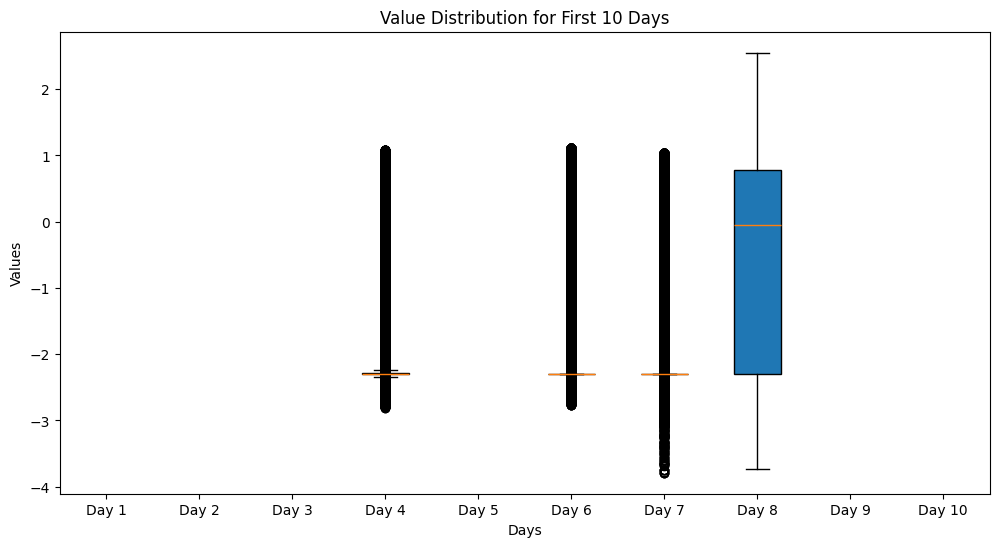

: 

In [60]:
# Select the first 10 days
first_10_days = ppt_log_normalized[10:20, :, :]

# Flatten each day's 2D array into 1D array for plotting
flattened_data = [first_10_days[day].flatten() for day in range(10)]
print(flattened_data)
# Plotting
plt.figure(figsize=(12, 6))

# Correcting tick_labels to xticklabels
plt.boxplot(flattened_data, vert=True, patch_artist=True)

# Adding labels and titles
plt.title('Value Distribution for First 10 Days')
plt.xlabel('Days')
plt.ylabel('Values')

# Setting x-axis labels
plt.xticks(ticks=range(1, 11), labels=[f'Day {i+1}' for i in range(10)])

# Displaying the plot
plt.show()